In [1]:
import torch
import pandas as pd
import numpy as np
from numpy import random
import torch.nn as nn

from modules import UNet_conditional
from diffusion import *
from utils import *
from evaluate import *
from torch.amp import autocast
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from tabulate import tabulate

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
device_name = 'cuda:1'
name = "stgF_ddim_e30_bs16_do10_cgt10_cg3"

#-------------------------------------------------------------
test_data_path = "../data/test_data_stg7_norm.csv"
predictions_path = "results/predictions/preds_" + name + ".csv"
model_path = "models/" + name + "/ema_ckpt.pt"

# Make predictions on test data

In [3]:
print("Loading: ", model_path)

device = torch.device(device_name if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = UNet_conditional(device=device, sampler_type="DDIM").to(device)
ckpt = torch.load(model_path,
                  map_location=device,
                  weights_only=True
                  )
model.load_state_dict(ckpt)

sampler = SpacedDiffusion(beta_start=1e-4,
                          beta_end=0.02,
                          noise_steps=1000,
                          section_counts=[40],
                          device=device)

Loading:  models/stgF_ddim_e30_bs16_do10_cgt10_cg3/ema_ckpt.pt
Using device: cuda:1


In [ ]:
x_real, cond_vectors, predictions = evaluate(model,
                      sampler,
                      device,
                      test_data_path,
                      s_type='ddim'
                    )
x_real = np.array(x_real)
cond_vectors = np.array(cond_vectors)
predictions = np.array(predictions)

Testing loop:  46%|███████████████▌                  | 8451/18408 [3:28:30<3:30:04,  1.27s/it]

In [7]:
x_real

array([[-1.        , -1.        , -1.        , ..., -0.99475908,
        -1.        , -0.99769253],
       [-0.99905491, -1.        , -1.        , ..., -0.99475908,
        -0.99552006, -0.99769253],
       [-0.99905491, -1.        , -1.        , ..., -0.9996686 ,
        -0.99552006, -0.9989199 ],
       ...,
       [-1.        , -1.        , -1.        , ..., -0.99475908,
        -0.99674743, -0.99769253],
       [-0.99905491, -1.        , -0.99874806, ..., -0.99844122,
        -0.99674743, -1.        ],
       [-0.99905491, -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ]])

In [9]:
predictions[:, 0, 0, :]

array([[-0.98984146, -0.98402888, -0.98422158, ..., -0.97959673,
        -0.97263896, -0.97635412],
       [-0.9979921 , -0.98547339, -0.9893651 , ..., -0.98593706,
        -0.9769001 , -0.98469406],
       [-0.94006002, -0.9609797 , -0.95741588, ..., -0.95797515,
        -0.94462681, -0.96107942],
       ...,
       [-0.97202098, -0.95865971, -0.9603613 , ..., -0.93920684,
        -0.91048449, -0.89134574],
       [-0.99843591, -0.99064052, -0.98467499, ..., -0.97098744,
        -0.98777938, -0.96323901],
       [-0.89105558, -0.93317199, -0.91316986, ..., -0.89890808,
        -0.90065223, -0.85468316]])

In [10]:
mse = np.mean((x_real - predictions[:, 0, 0, :]) ** 2)
print(f"Mean test mse error: {mse}")

Mean test mse error: 0.21498186091633067


# Save predictions

In [12]:
x_real_str = [','.join(map(str, row)) for row in x_real]
cond_vectors_str = [','.join(map(str, row)) for row in cond_vectors]
preds_str = [','.join(map(str, row)) for row in predictions[:, 0, 0, :]]

df = pd.DataFrame({'x_real': x_real_str, 'cond_vectors': cond_vectors_str, 'predictions': preds_str})
df.to_csv(predictions_path, index=False)

In [13]:
df.head()

,x_real,cond_vectors,predictions
0,"-1.0,-1.0,-1.0,-0.9904142022132874,-0.99119967...",,"-0.9898414611816406,-0.9840288758277893,-0.984..."
1,"-0.9990549087524414,-1.0,-1.0,-0.9891868233680...",,"-0.9979920983314514,-0.9854733943939209,-0.989..."
2,"-0.9990549087524414,-1.0,-1.0,-0.9928689599037...",,"-0.940060019493103,-0.960979700088501,-0.95741..."
3,"-1.0,-1.0,-0.9975206851959229,-0.9940963387489...",,"-0.9320271015167236,-0.9003692269325256,-0.919..."
4,"-0.9953727722167969,-1.0,-1.0,-0.9940963387489...",,"-0.9106378555297852,-0.9340698719024658,-0.872..."


In [14]:
# Function to convert comma-separated strings to lists of floats
def str_to_float_list(s):
    return np.array(list(map(float, s.split(','))))

x_real = np.array([str_to_float_list(row) for row in df['x_real']])
cond_vectors = np.array([str_to_float_list(row) for row in df['cond_vectors']])
predictions = np.array([str_to_float_list(row) for row in df['predictions']])

df.head()

ValueError: could not convert string to float: ''

# Intro into data

In [ ]:
# Find indices and values greater than 0.5
indices = np.where(np.any(x_real > 0.5, axis=1))[0]
filtered_values = [x_real[idx][x_real[idx] > 0.5] for idx in indices]
filtered_predictions = [predictions[idx][x_real[idx] > 0.5] for idx in indices]

# Flatten results and take the first 50
flat_filtered_values = np.concatenate(filtered_values)[:50]
flat_filtered_predictions = np.concatenate(filtered_predictions)[:50]

# Print the results side by side
print("Filtered Values (greater than 0.5) from x_real and corresponding Predictions:")
for value, prediction in zip(flat_filtered_values, flat_filtered_predictions):
    print(f"{value:.5f}\t\t\t{prediction:.5f}")

In [ ]:
# Find indices where predictions > 0.8 and corresponding x_real < 0.5
indices = np.where((predictions > 0.8) & (x_real < 0.1))

# Extract filtered values from x_real and predictions
filtered_x_real = x_real[indices]
filtered_predictions = predictions[indices]

# Print the results side by side
print("Filtered x_real (values < 0.1) and corresponding Predictions (values > 0.8):")
for x_val, pred_val in zip(filtered_x_real.flatten(), filtered_predictions.flatten()):
    print(f"{x_val:.5f}\t\t\t{pred_val:.5f}")

# Visualization of results

In [15]:
wavelengths = np.load('../data/wavelengths.npy')

In [16]:
wavelengths

array([ 634.835144,  635.296997,  635.758911, ..., 1123.063232,
       1123.557739, 1124.052368])

## Plot predictions

In [ ]:
create_spectrogram(wavelengths, predictions, label="Spectrogram of Intensities by Wavelength")

In [ ]:
create_spectrogram(wavelengths, x_real, label="Spectrogram of Intensities by Wavelength")

In [ ]:
create_difference_spectrogram(wavelengths, 
                              x_real, 
                              predictions, 
                              label="Difference Spectrogram of Real vs Predicted Intensities")

In [ ]:
create_combined_spectrogram(wavelengths, 
                            x_real, 
                            predictions)

## Influence of parameters to predictions

ValueError: x and y must have same first dimension, but have shapes (1024,) and (1, 1, 1024)

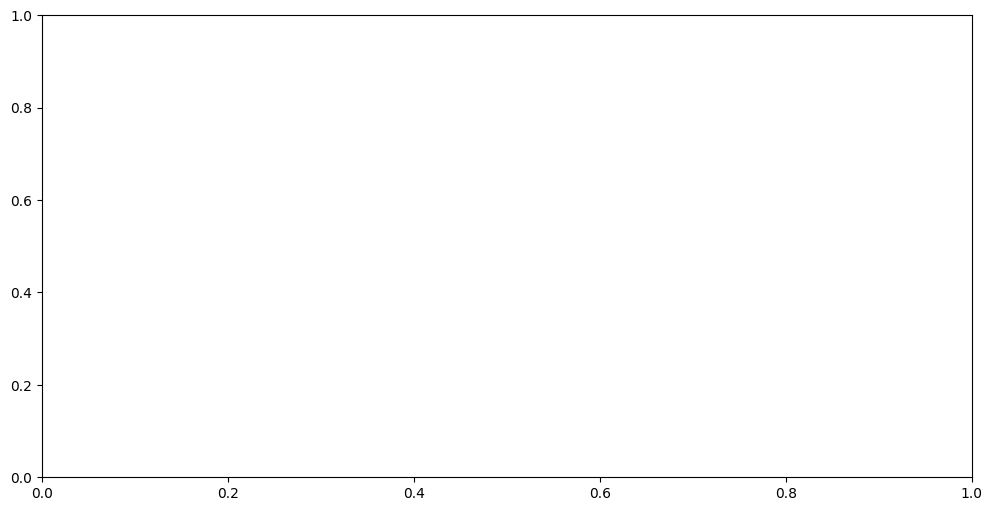

In [17]:
plot_random_intensity_vectors(wavelengths, predictions, cond_vectors)

In [ ]:
indices = np.random.choice(len(x_real), size=10, replace=False)

selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, indices, num_vectors=10
)

In [ ]:
worst_indices = get_worst_mse_indices(x_real, predictions, n=10)
selected_real, selected_predicted, selected_conditions = plot_combined_intensity_vectors_with_parameters(
    wavelengths, x_real, predictions, cond_vectors, worst_indices, num_vectors=10
)

In [ ]:
mse_stats = mse_statistics(x_real, predictions)


Number of vectors with high MSE (above upper whisker): 110
Number of vectors with low MSE (below or equal to upper whisker): 1457

Statistics for high MSE conditional vectors:
  Mean: [0.49549751 0.3924143  0.01770833]
  Median: [0.43446456 0.39480172 0.        ]
  Std: [0.21464057 0.21596775 0.07798785]
  Min: [0.19830993 0.01413967 0.        ]
  Max: [0.99751323 0.97253394 0.43452382]

Statistics for low MSE conditional vectors:
  Mean: [0.43744397 0.4618335  0.00552444]
  Median: [0.41639015 0.4775489  0.        ]
  Std: [0.16366634 0.21204912 0.04638001]
  Min: [0.         0.00644275 0.        ]
  Max: [1.         1.         0.64880955]


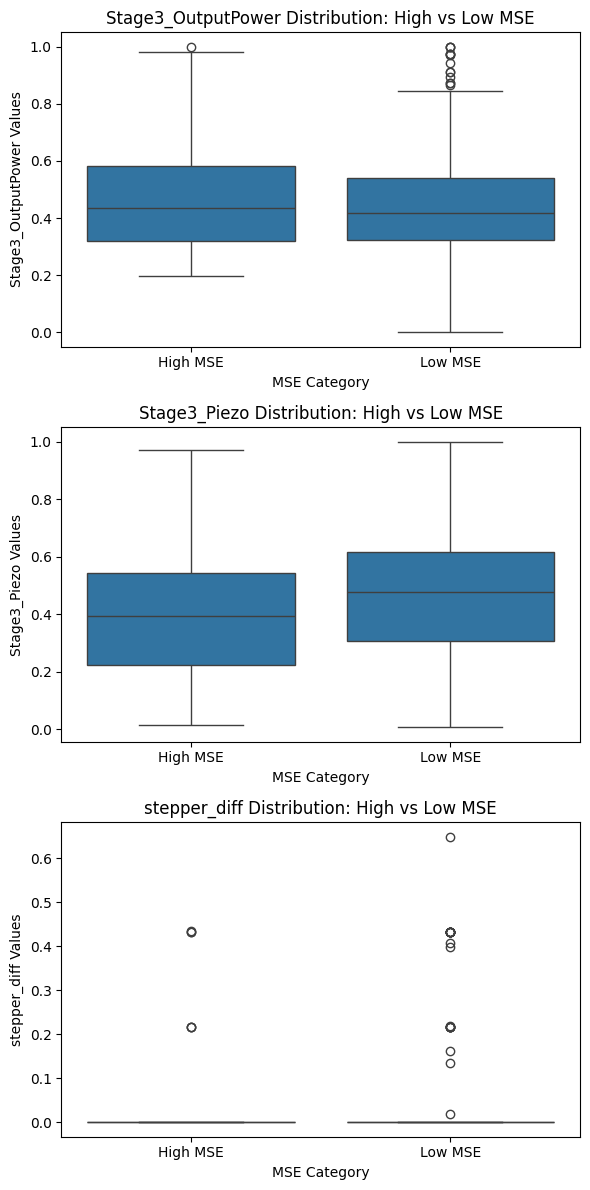

In [21]:
mse = np.mean((x_real - predictions) ** 2, axis=1)
parameter_names = ['Stage3_OutputPower', 'Stage3_Piezo', 'stepper_diff']
analyze_mse_and_cond_vectors(mse, cond_vectors, parameter_names)

## Try Random conditional vectors

In [22]:
df = pd.read_csv("../data/test_data_1024_[-1,1].csv")
df_subset = df.head(20)
new_cond_vectors = np.array([
    [ 214935.09855301,  269804.25447773, -418456.16068934],
    [ -93975.81857062,  120292.39937219,   82977.52669794],
    [ -93975.81857062,  -120292.39937219,   82977.52669794],
    [0,   0,   0],
    [  1,   1,  1],
    
    [ 1,    0,   0],
    [ 0,    1,   0],
    [ 0,    0,   1],
    [1,   1,   0],
    [  0,   1,  1],
    
    [ 1,    0,   1],
    [ 0.1,    0.1,   0],
    [ 0.3,    0.3,   0],
    [ 0.5,    0.5,   0],
    [ 0.7,    0.7,   0],
    
    [ 0.9,    0.9,   0],
    [ 0.1,    0.9,   0],
    [ 0.9,    0.1,   0],
    [ 0.5,    0.3,   0],
    [ 0.3,    0.5,   0],

])

df_subset['cond_vector'] = new_cond_vectors.tolist()
df_subset.to_csv("../data/data_nonsense.csv", index=False)

/tmp/ipykernel_2755021/1094714582.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['cond_vector'] = new_cond_vectors.tolist()


In [23]:
df_subset

,time,idx,cond_vector,intensities
0,2024-06-17 10:11:38.558800220,18,"[214935.09855301, 269804.25447773, -418456.160...","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
1,2024-06-17 10:20:03.601318836,80,"[-93975.81857062, 120292.39937219, 82977.52669...","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
2,2024-06-17 10:15:08.508659840,48,"[-93975.81857062, -120292.39937219, 82977.5266...","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
3,2024-06-17 10:12:54.698517799,40,"[0.0, 0.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
4,2024-06-17 10:17:33.703059673,57,"[1.0, 1.0, 1.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
5,2024-06-17 10:23:07.478772640,116,"[1.0, 0.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
6,2024-06-17 10:25:01.330039501,119,"[0.0, 1.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
7,2024-06-17 10:16:29.521095276,57,"[0.0, 0.0, 1.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
8,2024-06-17 10:13:30.400424957,40,"[1.0, 1.0, 0.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."
9,2024-06-17 10:22:44.214152813,101,"[0.0, 1.0, 1.0]","-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-..."


In [24]:
x_real_nonsense, cond_vectors_nonsense, predictions_nonsense = evaluate(model,
                      sampler,
                      device,
                     "../data/data_nonsense.csv",
                                            s_type='edm')
x_real_nonsense = np.array(x_real_nonsense)
cond_vectors_nonsense = np.array(cond_vectors_nonsense)
predictions_nonsense = np.array(predictions_nonsense)[:,0,0,:]

Testing loop: 100%|███████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


In [25]:
predictions_nonsense

array([[-0.42708331,  0.36458337, -0.41666669, ...,  0.33072913,
         0.3359375 , -0.16666669],
       [ 0.88826811,  0.30446923, -0.55446929, ...,  0.46787715,
        -0.1913408 ,  0.58100557],
       [ 0.21810186, -0.38906348,  0.22564423, ...,  0.21307349,
         0.43683219, -0.17598993],
       ...,
       [-0.99758756, -0.9984802 , -0.9988296 , ..., -0.99738014,
        -0.99789745, -1.        ],
       [-0.99788058, -0.99927235, -1.        , ..., -0.99879831,
        -0.99766415, -0.99715632],
       [-0.99693412, -0.99771982, -0.99763656, ..., -0.99835968,
        -0.99873012, -0.99645895]])

In [26]:
x_real_nonsense

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

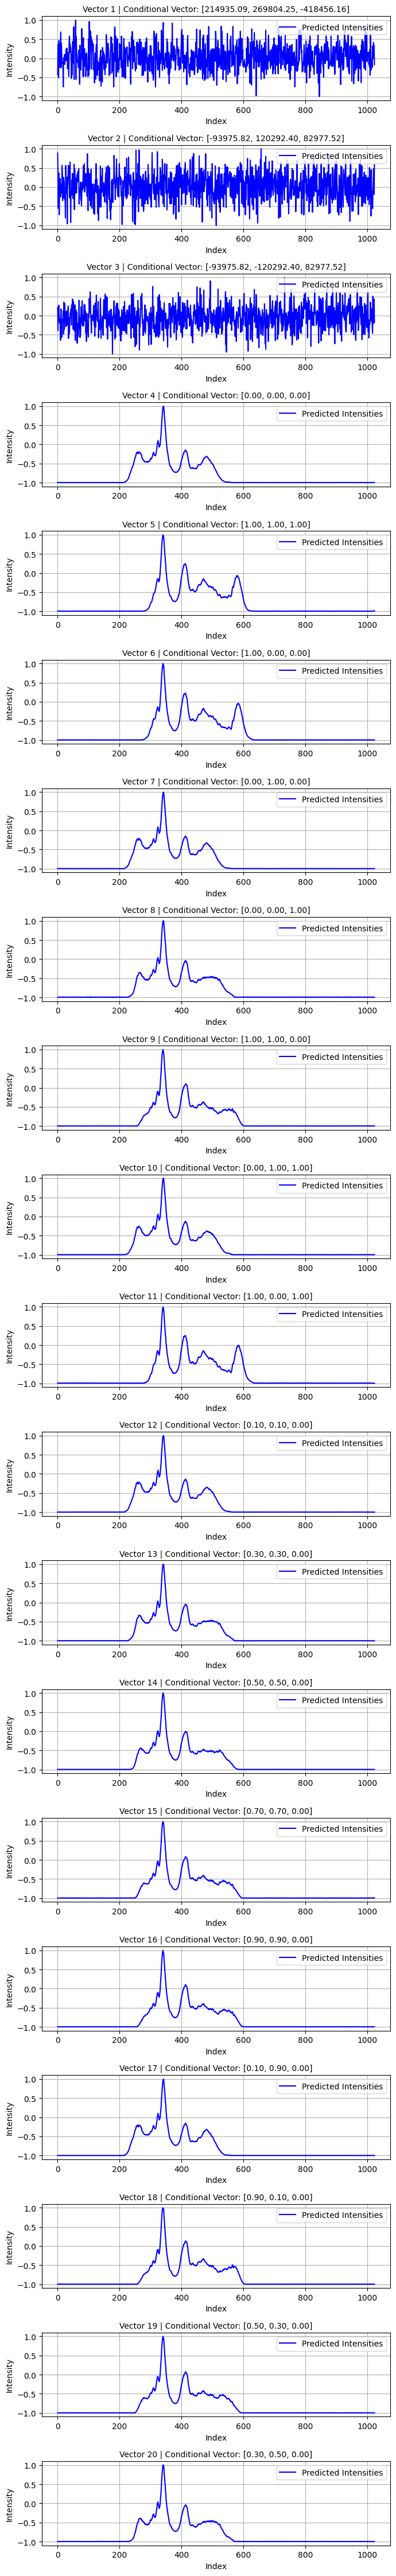

In [27]:
plot_predictions_with_cond_vectors(predictions_nonsense, cond_vectors_nonsense)

## Compare distributions

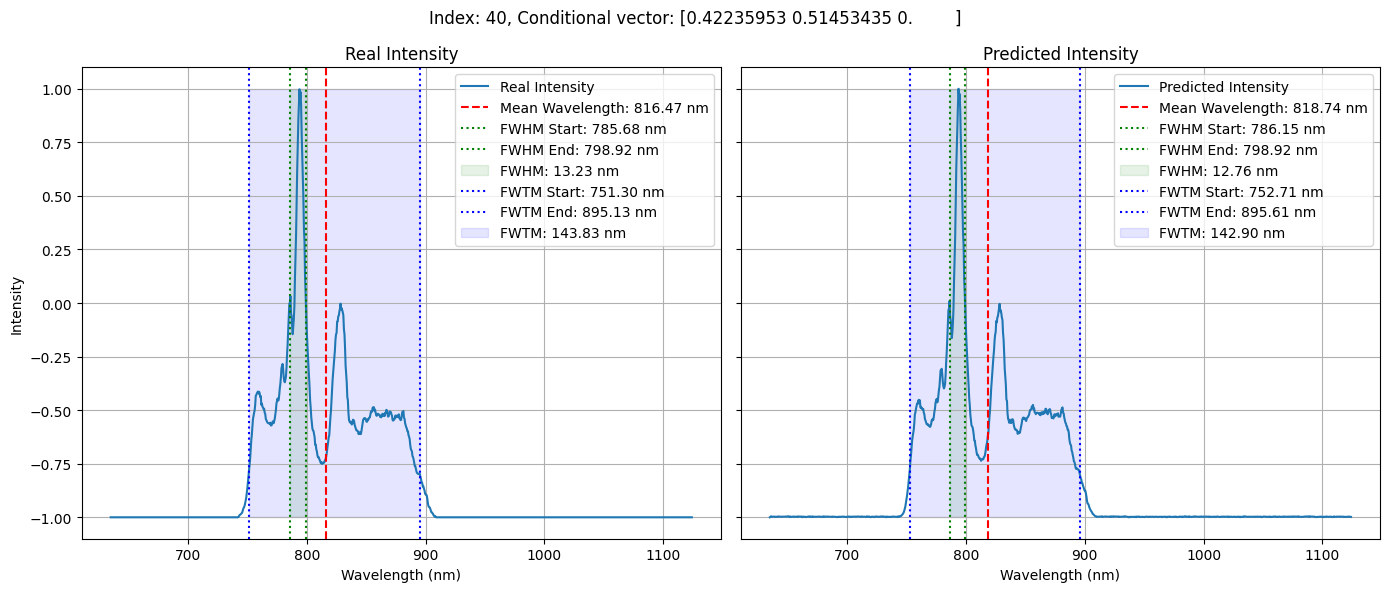

In [28]:
plot_comparison(index=40, wavelengths=wavelengths, x_real=x_real, predictions=predictions, cond_vectors=cond_vectors)

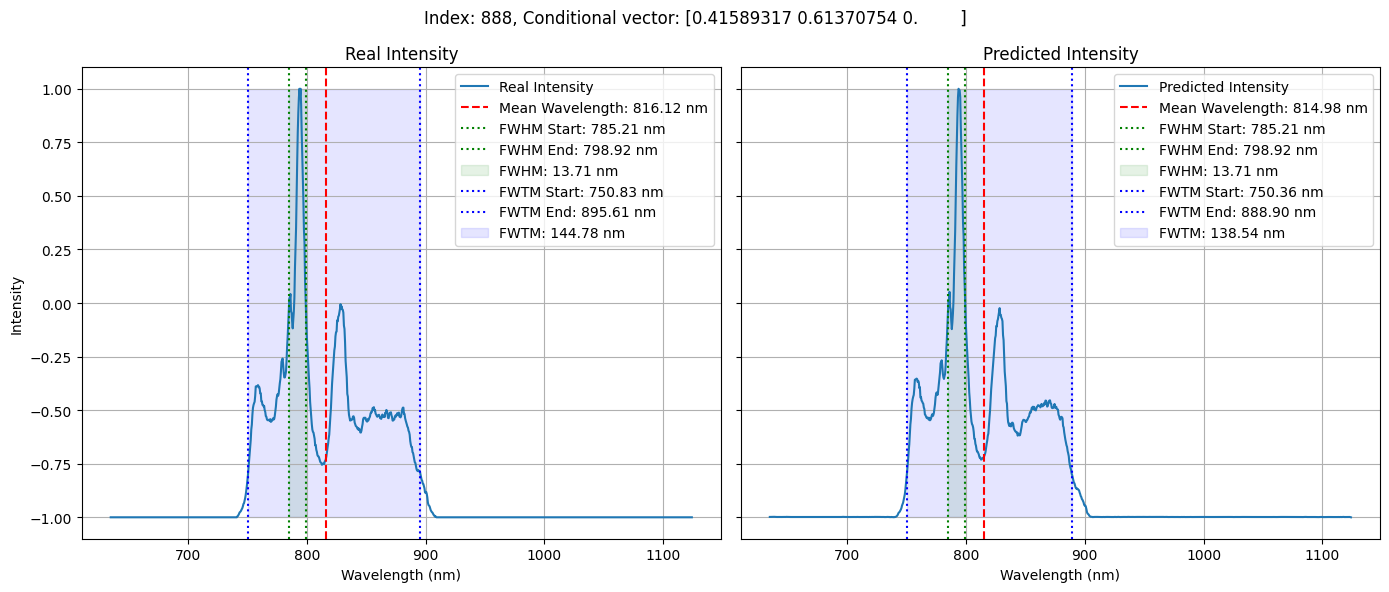

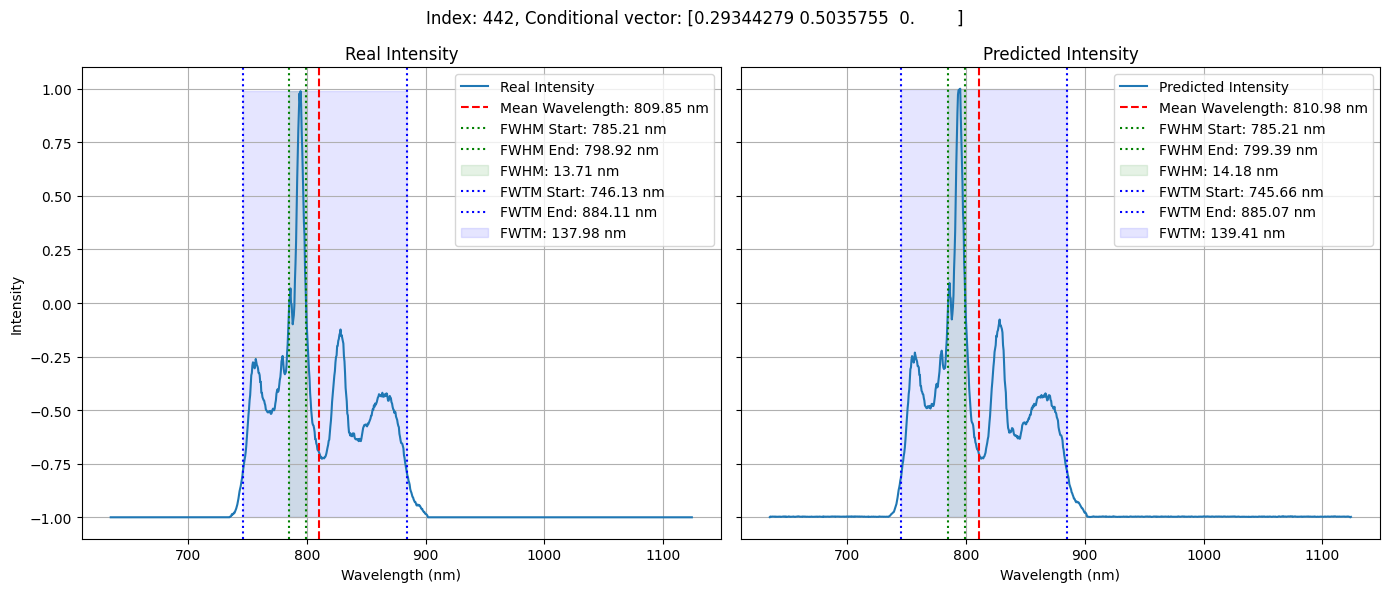

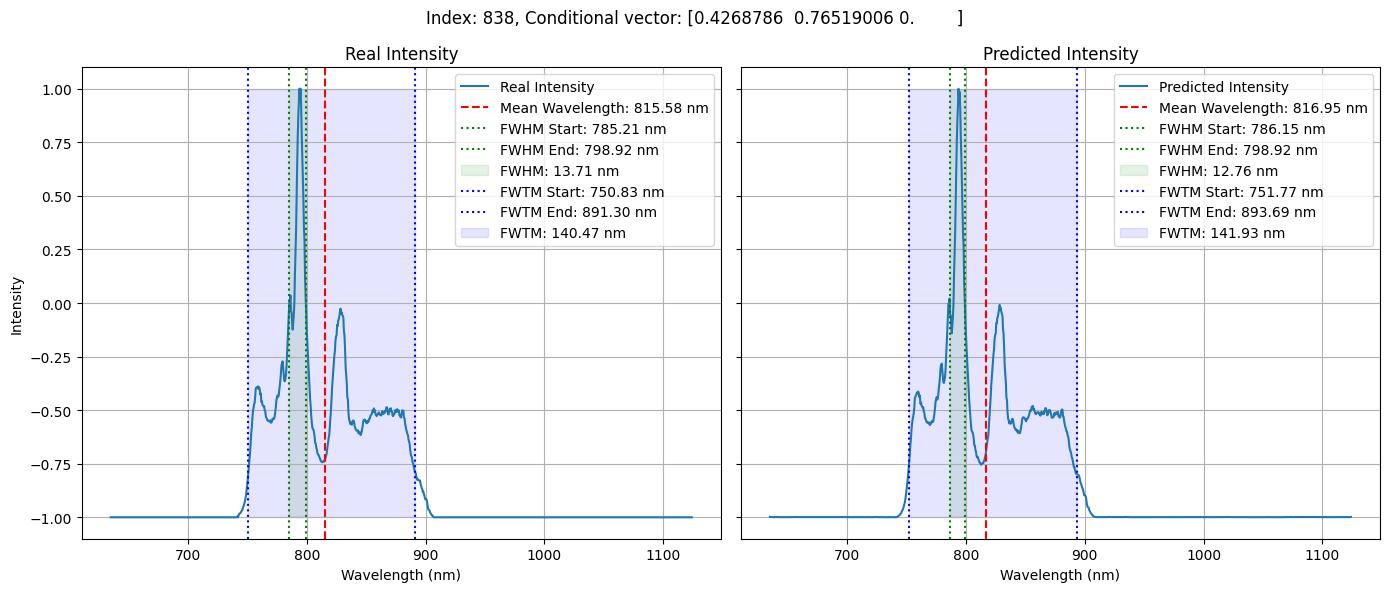

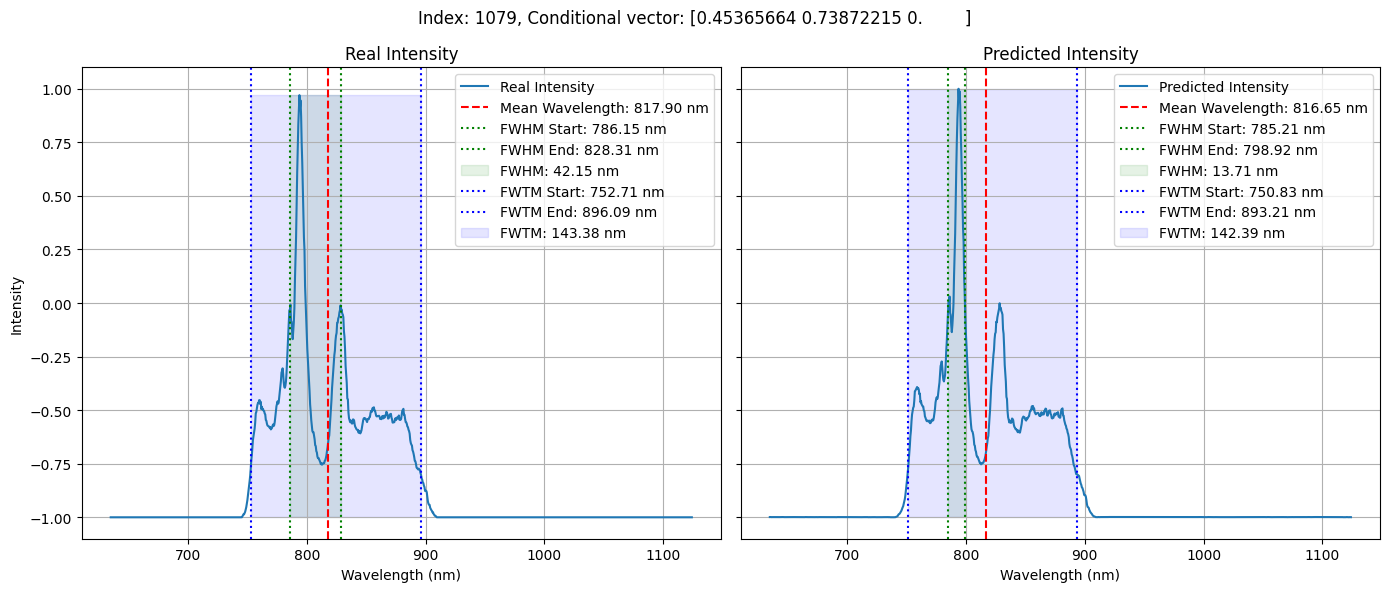

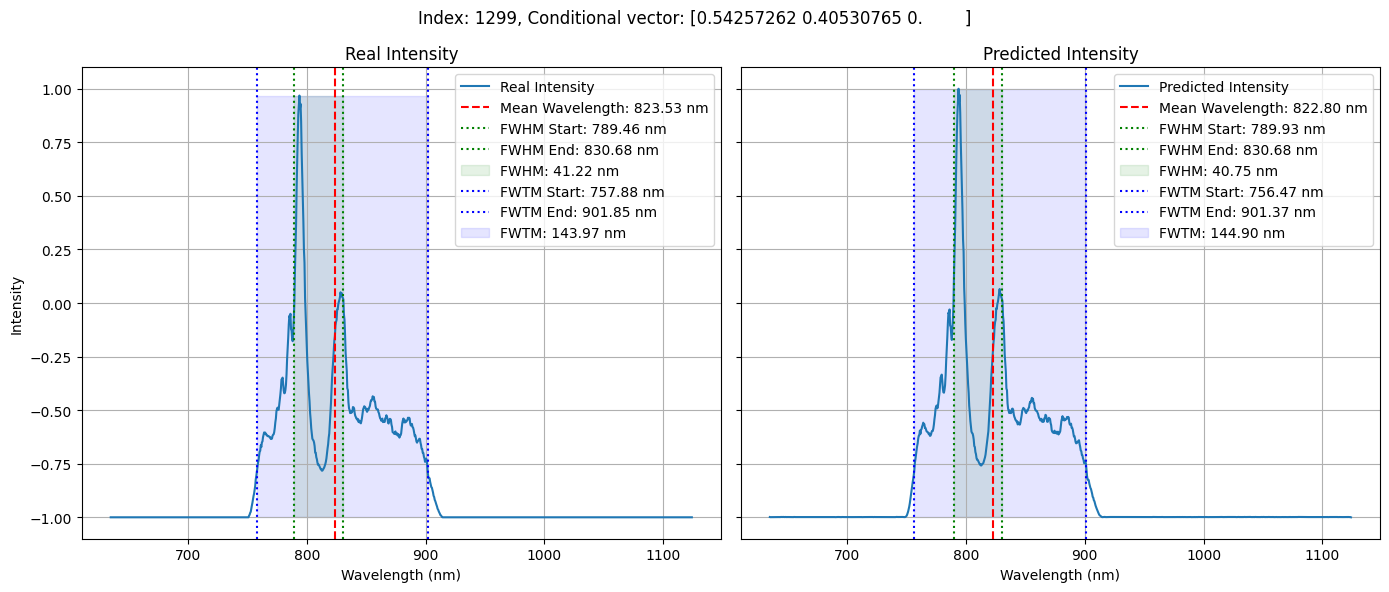

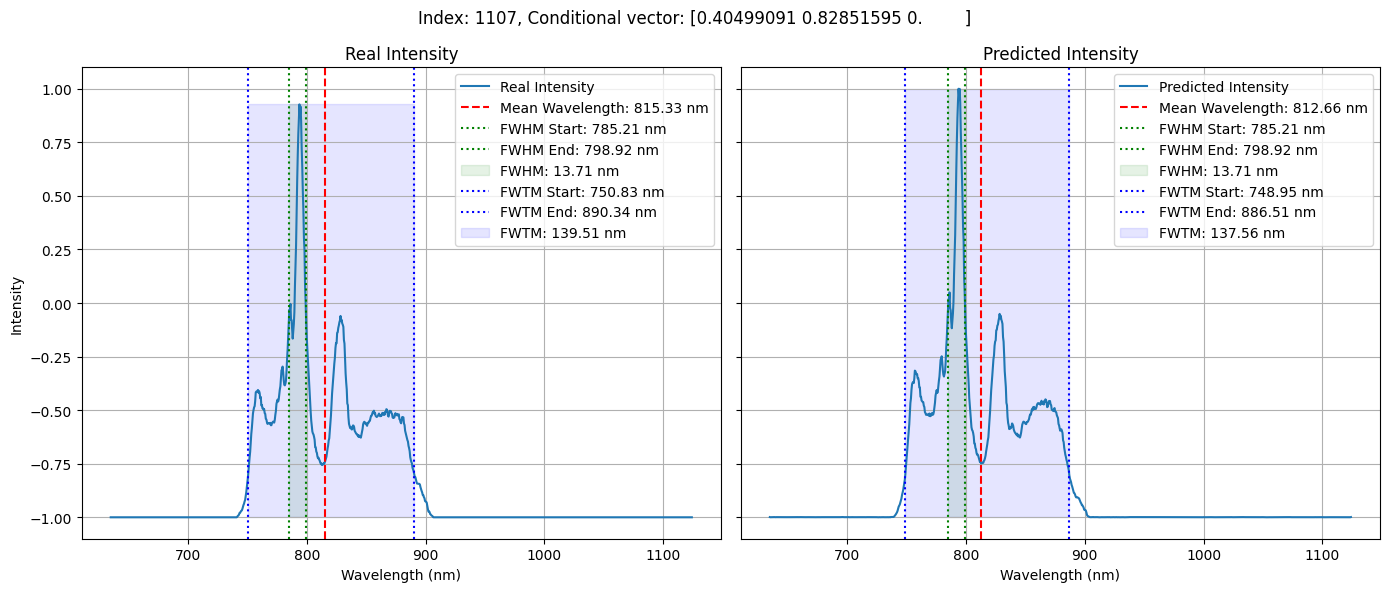

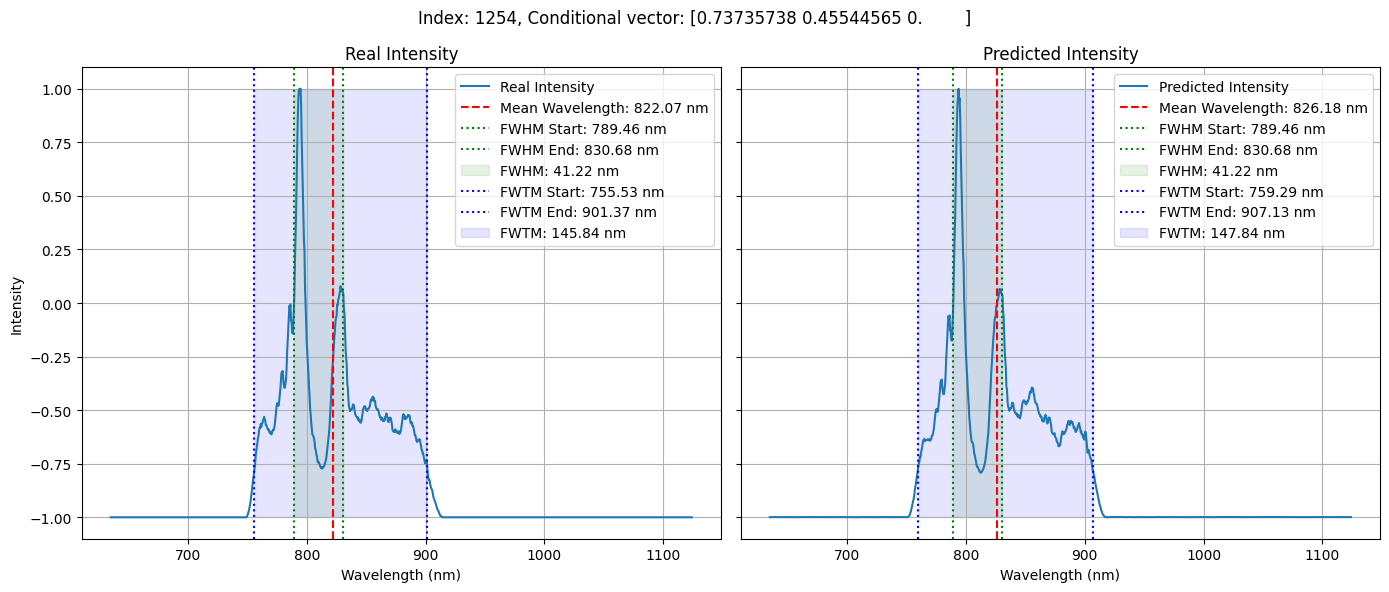

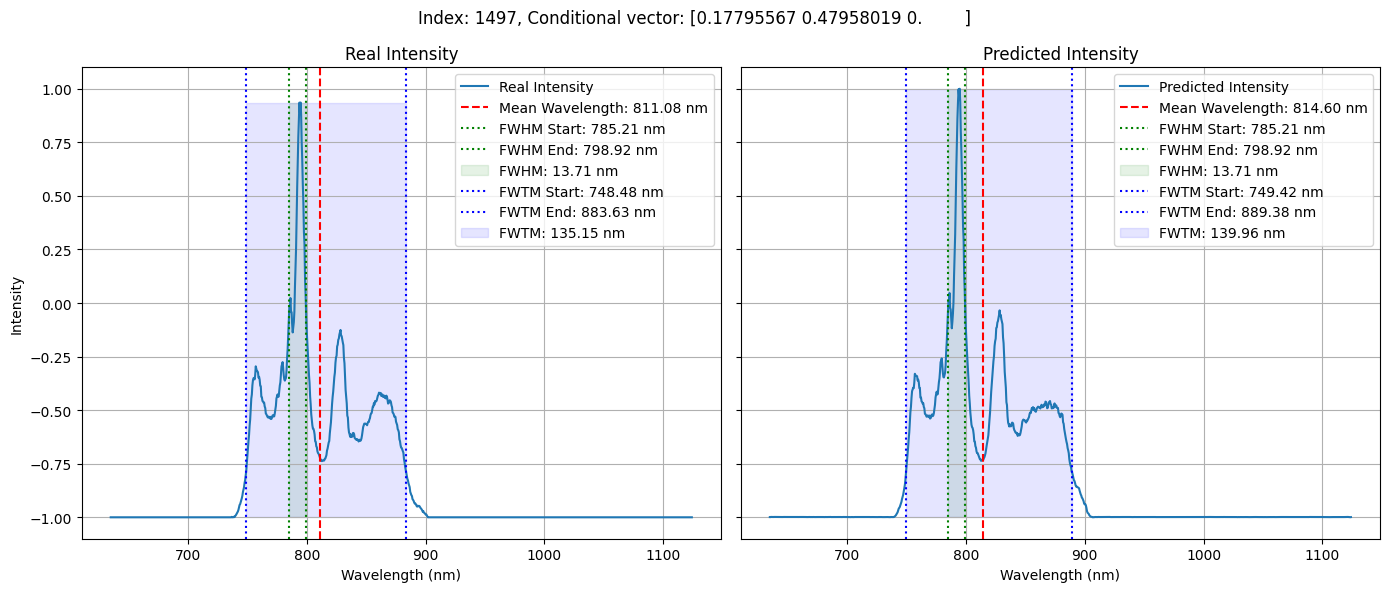

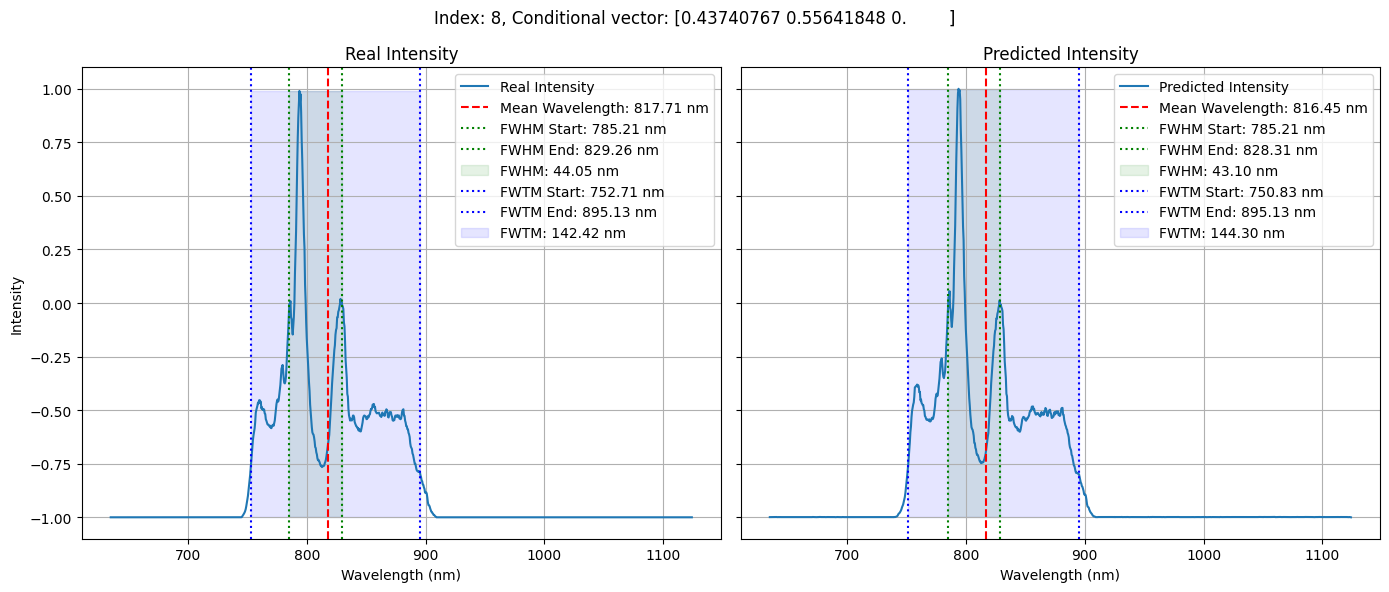

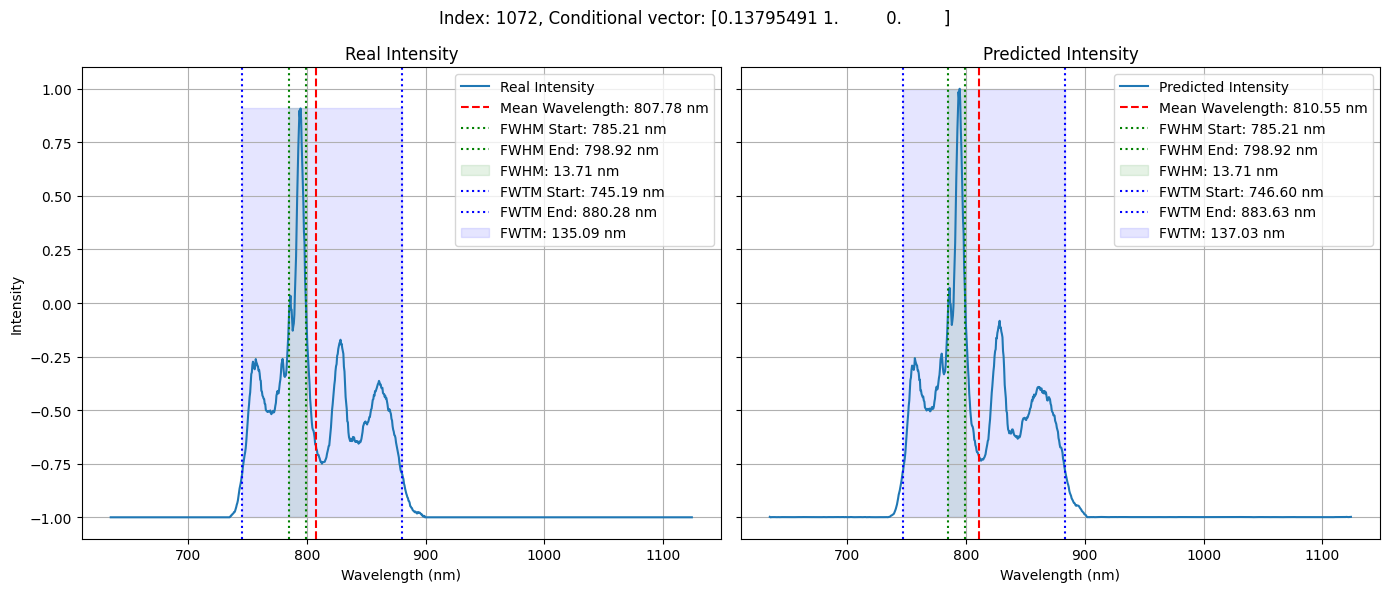

In [29]:
rand_ind = random.randint(len(x_real), size=(10))
for i in rand_ind:
    plot_comparison(index=i, wavelengths=wavelengths, x_real=x_real, predictions=predictions, cond_vectors=cond_vectors)

In [30]:
# Calculate MSE and MAE for the metrics
mse_results, mae_results = calculate_metrics_errors(wavelengths, x_real, predictions)

+-----------------+-----------+---------+
| Metric          |       MSE |     MAE |
+=================+===========+=========+
| mean_wavelength |  19.3453  | 3.47212 |
+-----------------+-----------+---------+
| std_deviation   |   5.3941  | 1.98519 |
+-----------------+-----------+---------+
| fwhm            | 227.078   | 8.50332 |
+-----------------+-----------+---------+
| fwhm_start      |   4.21443 | 1.19235 |
+-----------------+-----------+---------+
| fwhm_end        | 247.828   | 8.33681 |
+-----------------+-----------+---------+
| fwtm            |  10.7259  | 2.47847 |
+-----------------+-----------+---------+
| fwtm_start      |  13.6667  | 2.83357 |
+-----------------+-----------+---------+
| fwtm_end        |  37.7092  | 4.82432 |
+-----------------+-----------+---------+


In [31]:
calculate_dtw_distances(x_real, predictions)

TypeError: unsupported operand type(s) for +: 'DTW' and 'DTW'